# Machine Learning (MScA, 2009)

# Introduction to TensorFlow, Part 3

### Yuri Balasanov, Mihail Tselishchev, &copy; 2018



# Data 

Example in this notebook is [**breast cancer wisconsin dataset**](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+&#40;Diagnostic&#41;). 

The breast cancer dataset is a well known data for binary classification. It was created by Dr. William H. Wolberg, physician at the University Of Wisconsin Hospital at Madison, Wisconsin, USA.

Features are created from a digitized images of a [fine needle aspirate (FNA)](https://en.wikipedia.org/wiki/Fine-needle_aspiration), a biopsy method, of a breast mass. They describe characteristics of the cell nuclei present in the image.

To create the dataset Dr. Wolberg used ﬂuid samples, taken from patients with solid breast masses and graphical software [Xcyt](http://software.broadinstitute.org/mpg/xcyt/) capable of performing analysis of cytological features on a digital scan. 

Main research article on the subject of this analysis, including an image of malignant cells, is [Wisconsin Breast Cancer Dataset and Machine Learning for Breast Cancer Detection, by Lucas Rodrigues Borges](https://www.researchgate.net/publication/311950799_Analysis_of_the_Wisconsin_Breast_Cancer_Dataset_and_Machine_Learning_for_Breast_Cancer_Detection [accessed Nov 09 2017]).

The data set has following characteristics:

- Classes:	2
- Samples per class:	212(malignant), 357(benign)
- Samples total:	569
- Dimensionality:	30
- Features:	real, positive

Load the data using utility *load_breast_cancer* from *sklearn.datasets* module. <br>
Print names of the features and dimensions of the data.

In [1]:
%matplotlib inline
# loading data
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
print(data.feature_names)
print('data', data.data.shape, 'labels', data.target.shape)

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
data (569, 30) labels (569,)


In [2]:
n_inputs = data.data.shape[1]
print('Number of inputs =',n_inputs)

Number of inputs = 30


Separate data into train and test samples

In [3]:
# prepare test and train sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data.data, 
                                                    data.target,
                                                    test_size=0.2)

# Architecture of the network 

A possible architecture for the network may have 2 dense hidden layers of 5 and 10 units folowed by a sigmoid activation function. 
The following plot displays the nework architecture and explains the nature of **Dense** (fully connected) layer: each neuron of it is connected with all input variables of the next layer.
 
![Model plot](https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FLecture%207%20AdvML%2FR_nn_plot.png)

The picture was created with function *plot()* from R **neuralnet** package. <br>


Alternatively the network can have 3 layers of 5, 10 and 2 units, followed by a softmax activation function, like in the plot below.

![Model plot](https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Data%20Mining%20and%20Predictive%20Analytics%2031009%2FLecture%20Deep%20Learning%2FWBCD_5_10_2_Architecture.png)

This plot was also created in R **neuralnet** package.

**Explain why these two architectures can be used to train the same binary classification model**.

# Creating neural network in TensorFlow

## Construction phase

Use TensorFlow Python API to construct graph for the neural network.

### 1. Create placeholder nodes for training inputs and the target 

We need placeholder because shape is only partially defined prior to calculation. Another placeholder node is a flag deciding whether the sample is train or test.

In [4]:
import tensorflow as tf

tf.reset_default_graph()
x = tf.placeholder('float32', shape=(None, n_inputs), name='x')
y = tf.placeholder('int64', (None, ), name='y')
is_training = tf.placeholder(tf.bool, shape=(), name='is_training')
print('Shape of "x" =',x.shape)
print('Shape of "y" =',y.shape)
print('Shape of "is_training" =',is_training.shape)

Shape of "x" = (?, 30)
Shape of "y" = (?,)
Shape of "is_training" = ()


### 2. Create layers

The following methods from TensorFlow module `contrib.layers` normalize the inputs, set the layers and define the output

**Method `batch_norm()`**

Can be used as a normalizer function for conv2d and fully_connected.
Syntax (not all arguments shown):

`batch_norm(inputs,center=True,scale=False,activation_fn=None,is_training=True,scope=None)`

where

- `inputs`: a tensor with 2 or more dimensions, where the first dimension has batch_size. In this default case the normalization is over all but the last dimension;
- `center`:  if True, add intercept $\beta$ to normalized tensor. If False, $\beta$ is ignored. See ["Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift" by Sergey Ioffe, Christian Szegedy](http://arxiv.org/abs/1502.03167) for notations and details;
- `scale`: if True, multiply by slopes $\gamma$. If False, $\gamma$ is not used. See link above for notations and further details;
- `scope`: ensures that the name of created variable is used properly within the scope of the current graph.
- `is_training`: whether or not the layer is in training mode. In training mode it would accumulate the statistics of the moments into moving_mean and moving_variance using an exponential moving average with the given decay. When it is not in training mode then it would use the values of the moving_mean and the moving_variance.

**Method `fully_connected()`**

Adds a fully connected layer.
Syntax (not all arguments shown):

`fully_connected(inputs,num_outputs,activation_fn=tf.nn.relu,scope=None)`

where

- `inputs`: a tensor of at least rank 2 and static value for the last dimension; for example, [batch_size, depth], [None, None, None, channels];  
- `num_outputs`: integer or long, the number of output units in the layer; 
- `activation_fn=tf.nn.relu`: activation function. The default value is a ReLU function. Explicitly set it to None to skip it and maintain a linear activation; 
- `scope`: same as above


In [5]:
# scale inputs
scaled = tf.contrib.layers.batch_norm(x, center=True, scale=True, scope='scaled',
                                      is_training=is_training)
# hidden layer 1
hidden1 = tf.contrib.layers.fully_connected(scaled, num_outputs=5, scope='hidden1',
                                            activation_fn=tf.nn.relu)
# hidden layer 2
hidden2 = tf.contrib.layers.fully_connected(hidden1, num_outputs=10, scope='hidden2',
                                            activation_fn=tf.nn.relu)
# instead of final sigmoid returning 1 number p between 0 and 1
# use softmax returning a pair of numbers p and 1-p
logits = tf.contrib.layers.fully_connected(hidden2, num_outputs=2, scope='logits',
                                           activation_fn=None)
# apply softmax to make 2 numbers add to 1
output = tf.nn.softmax(logits, name='output')

### 3. Prepare measures of goodness of fit: accuracy and logloss for logging

The methods in the following cell are:

**reduce_mean**

Calculates mean of onput tensor along given dimensions.
Syntax is (not all arguments shown):

*reduce_mean(input_tensor,axis=None)*

where *axis* is the dimension of averaging; when None then all dimensions are reduced (returns a number).

**Example**:

x = tf.constant([[1., 1.], [2., 2.]]) <br>
xBar=tf.reduce_mean(x)                   # total average   <br>
xApplyColumn=tf.reduce_mean(x, axis=0)   # average by column  <br>
xApplyRow=tf.reduce_mean(x, axis=1)      # average by row <br>
with tf.Session() as sess: <br>
> print (sess.run(x)) <br>
> print(sess.run(xBar)) <br>
> print(sess.run(xApplyColumn)) <br>
> print(sess.run(xApplyRow)) <br>

[[ 1.  1.] <br>
 [ 2.  2.]] <br>
1.5 <br>
[ 1.5  1.5] <br>
[ 1.  2.] <br>

**cast**

Casts tensor into a data type *dtype*

*cast(x,dtype,name=None)*

**Example**:



x = tf.constant([1.8, 2.2], dtype=tf.float32) <br>
with tf.Session() as sess:  <br>
> print('Original: ',x,sess.run(x))  <br>
> print('Cast: ',tf.cast(x, tf.int32),sess.run(tf.cast(x, tf.int32)))  <br>

Original:  Tensor("Const_15:0", shape=(2,), dtype=float32) [ 1.79999995  2.20000005]  <br>
Cast:  Tensor("Cast_10:0", shape=(2,), dtype=int32) [1 2]  <br>

**sparse_softmax_cross_entropy_with_logits**

Calculates log loss function
$$logloss = -\frac{1}{N}\sum_{i=1}^N \sum_{j=1}^M y_{ij} \ln(p_{ij}),$$

where $y$ are labels and $\ln(p_{ij})$ are outputs of the layer *logits* defined above. <br>
Output of *logits* contains 2 numbers which are not normalized to add to 1. Operation *sparse_softmax_cross_entropy_with_logits* returns probabilities.

In [6]:
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(tf.equal(y, tf.argmax(logits, 1)),
                                      'float32'))
with tf.name_scope('logloss'):
    y_float = tf.cast(y, 'float32')
    logloss = tf.reduce_mean(
              tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits) )

Create nodes that will evaluate values and write it to a TensorBoard-compatible binary log string called a summary.

Operation *summary.merge_all()* merges all summaries collected in the default graph.

In [7]:
tf.summary.scalar("logloss", logloss)
tf.summary.scalar("accuracy", accuracy)

merged = tf.summary.merge_all()

## Training phase

Create a function that takes arguments:

- *n_epochs* - number of times entire train set runs through the network during the process of training;
- *batch_size* - number of observations in a batch; batch is a group of observations (i.e. rows of the data matrix) that will be fed through the network in back propagation cycle (feed forward, obtain predictions of the labels, calculate the loss, calculate the gradient, adjust the weights). Training the network in batches rather than one observation at a time helps speeding up training process, smoothing gradients and taking advantage of the power of GPUs which are efficient at doing array operations;
- *logdir* - name of the log directory.

In [8]:
def train(n_epochs, batch_size, logdir, trained_params_path):
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        # Ensures that we execute the update_ops before performing the train_step
        optimizer = tf.train.AdamOptimizer()
        # Select type of optimizer
        train_step = optimizer.minimize(logloss)
        # Gradient descent step
    sess = tf.Session()
    train_writer = tf.summary.FileWriter(logdir + '/train', sess.graph)
    test_writer = tf.summary.FileWriter(logdir + '/test')
    # Write summary to the log

    sess.run(tf.global_variables_initializer())  # Initialize all variables
    saver = tf.train.Saver()  # use saver to store trained model parameters on disk
    best_epoch = 0
    best_test_logloss = float("inf")
    test_accuracy_for_best_test_logloss = 0

    history = []
    for epoch in range(n_epochs):
        batch_from = 0
        while batch_from < len(y_train):
            batch_to = min(batch_from + batch_size, len(y_train))
            x_trainbatch = x_train[batch_from:batch_to,]
            y_trainbatch = y_train[batch_from:batch_to]
            batch_from = batch_from + batch_size  # for next iteration
            sess.run(train_step,
                     feed_dict={x: x_trainbatch, 
                                y: y_trainbatch, 
                                is_training: True})
        # Run batches through the network until epoch is over

        # Calculate statistics (logloss & accuracy) for train & test:
        train_res = sess.run([merged, logloss, accuracy], 
                             feed_dict={x: x_train, y: y_train, is_training: False})
        test_res  = sess.run([merged, logloss, accuracy], 
                             feed_dict={x: x_test,  y: y_test,  is_training: False})
        history += [[epoch] + train_res[1:] + test_res[1:]]
        train_writer.add_summary(train_res[0], epoch)
        test_writer.add_summary(test_res[0], epoch)  # Update history and write to the log
        test_logloss = test_res[1]
        test_accuracy = test_res[2]
        if test_logloss < best_test_logloss:
            # save params for best test logloss only
            saver.save(sess, trained_params_path)
            best_epoch = epoch
            best_test_logloss = test_logloss
            test_accuracy_for_best_test_logloss = test_accuracy
            
    print('Best epoch is #{} with test logloss of {:.4f} (test_accuracy = {:.4f})'\
            .format(best_epoch, best_test_logloss, test_accuracy_for_best_test_logloss))

    train_writer.flush()
    train_writer.close()
    test_writer.flush()
    test_writer.close()
    sess.close()
    return history

Now run network training process.

In [9]:
h = train(n_epochs=1000, batch_size=32, 
          logdir = './log/', trained_params_path='./fitted.params')
h[-10:]

Best epoch is #320 with test logloss of 0.1218 (test_accuracy = 0.9737)


[[990, 0.12401454, 0.97362638, 0.78693354, 0.94736844],
 [991, 0.12413789, 0.97362638, 0.78718692, 0.94736844],
 [992, 0.12404867, 0.97362638, 0.78743666, 0.94736844],
 [993, 0.12400958, 0.97362638, 0.7876913, 0.94736844],
 [994, 0.1241911, 0.97362638, 0.78794372, 0.94736844],
 [995, 0.12414104, 0.97362638, 0.78820735, 0.94736844],
 [996, 0.12411554, 0.97362638, 0.78846288, 0.94736844],
 [997, 0.12413415, 0.97362638, 0.78869283, 0.94736844],
 [998, 0.12406655, 0.97362638, 0.78891468, 0.94736844],
 [999, 0.12412852, 0.97362638, 0.7891466, 0.94736844]]

# Analyze the results 

Columns returned in `h` are:

- Epoch number
- Logloss for train sample
- Accuracy for train sample
- Logloss for test sample
- Accuracy for test sample

Check the results on TensorBoard using

*tensorboard --logdir=./log*

or see the history of training in the Notebook using returned variable `h`:

In [10]:
import numpy as np
df_h = np.asarray(h)
print(type(df_h), df_h.shape)

<class 'numpy.ndarray'> (1000, 5)


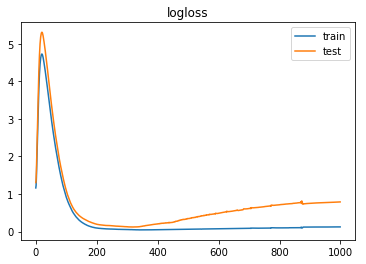

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot logloss for train & test
plt.plot(df_h[:,0], df_h[:,1], label='train')
plt.plot(df_h[:,0], df_h[:,3], label='test')
plt.title('logloss')
plt.legend()

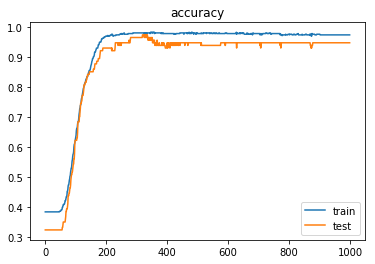

In [12]:
# Plot accuracy for train & test
plt.plot(df_h[:,0], df_h[:,2], label='train')
plt.plot(df_h[:,0], df_h[:,4], label='test')
plt.title('accuracy')
plt.legend()

Create a function that makes predictions for both classes.

This function uses *tf.train.Saver*. Class *tf.train* contains TensorFlow optimization tools. Class [Saver](https://www.tensorflow.org/api_docs/python/tf/train/Saver) adds ops to save and restore variables to and from checkpoints. It also provides convenience methods to run these ops.

Checkpoints are binary files in a proprietary format which map variable names to tensor values. The best way to examine the contents of a checkpoint is to load it using a Saver.


In [13]:
def predict(x_new, trained_params_path):
    with tf.Session() as sess:
        saver = tf.train.Saver()
        saver.restore(sess, trained_params_path)
        pr = output.eval(feed_dict={x: x_new, is_training: False})
        return pr

In [14]:
z = predict(x_test, './fitted.params')
print(z.shape)

INFO:tensorflow:Restoring parameters from ./fitted.params
(114, 2)


The following graph shows predicted probabilities of class 1. Blue dots correspond to true class 0 and orange dots correspond to true class 1.

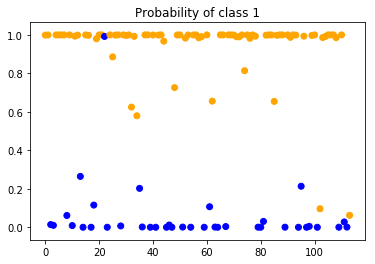

In [15]:
# blue for class 0, orange for class 1
color = ['blue' if y == 0 else 'orange' for y in y_test]
plt.scatter(range(y_test.shape[0]), z[:,1], color=color)
plt.title('Probability of class 1')

Try repeating running cells starting from model training. Observe different predictions after every training.  